In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score


import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

print(tf.__version__)
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    print('No Cuda GPU detected.')

2.4.1
No Cuda GPU detected.


In [2]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 300])
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)

In [3]:
def plotPred (y_true, preds):
    ymin = np.min(y_true)
    ymax = np.max(y_true)
    plt.scatter(y_true, preds, label=f'score: {r2_score(y_true, preds)}')
    plt.plot([ymin, ymax], [ymin, ymax], '-.', color='red', label="predicted values = true values")
    plt.xlabel('True values')
    plt.ylabel('Predicted values')
    plt.legend()

In [4]:
dataframe_encoded = pd.read_csv('Datasets/dataset.csv', nrows=500000)
features = dataframe_encoded.columns[:-1]
cps = dataframe_encoded.columns[-1]

X = dataframe_encoded[features].values
y = dataframe_encoded[cps].values
print(X.shape, y.shape)
dataframe_encoded.head()

(500000, 131) (500000,)


,0,1,2,3,4,5,6,7,8,9,...,122,123,124,125,126,127,whites to play,castling rights,en passant square,cp (Stockfish 13)
0,-1.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,4.0,0.0,0.0,1.0,0.0,-1.0,-1217.0
1,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,4.0,0.0,0.0,...,1.0,4.0,1.0,6.0,0.0,0.0,1.0,0.0,-1.0,-189.0
2,0.0,0.0,-1.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,3.0,0.0,0.0,1.0,4.0,1.0,0.0,-1.0,244.0
3,-1.0,4.0,-1.0,2.0,-1.0,3.0,-1.0,5.0,-1.0,6.0,...,1.0,3.0,1.0,2.0,1.0,4.0,1.0,15.0,-1.0,78.0
4,-1.0,4.0,-1.0,2.0,-1.0,3.0,-1.0,5.0,-1.0,6.0,...,1.0,4.0,1.0,6.0,0.0,0.0,1.0,8.0,-1.0,-459.0


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [6]:
input = tf.keras.Input(shape=(X.shape[1],))
output = layers.Dense(X.shape[1], activation='relu')(input)
output = layers.Dense(64, activation='relu')(output)
output = layers.Dense(1)(output)
model = keras.Model(inputs=input, outputs=output)

model.summary()
model.compile(loss='mean_absolute_error', optimizer='adam')

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 131)]             0         
_________________________________________________________________
dense (Dense)                (None, 131)               17292     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8448      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 25,805
Trainable params: 25,805
Non-trainable params: 0
_________________________________________________________________


CPU times: user 9min 37s, sys: 2min 43s, total: 12min 21s
Wall time: 5min 10s


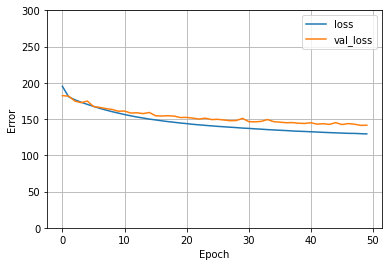

In [7]:
%%time
plot_loss(model.fit(X_train, y_train, validation_split=0.1, verbose=0, epochs=50))

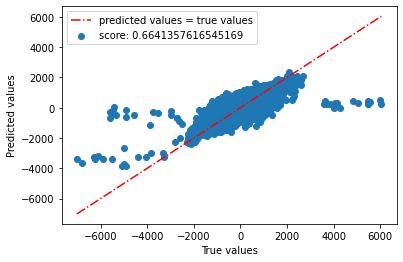

In [8]:
plotPred(y_test, model.predict(X_test).flatten())

In [9]:
test_df = pd.read_csv('Datasets/test_dataset.csv')
features = test_df.columns[:-1]
cps = test_df.columns[-1]

boards = test_df[features].values
scores = test_df[cps].values
print(boards.shape, scores.shape)
preds = model.predict(boards).flatten()

(200000, 131) (200000,)


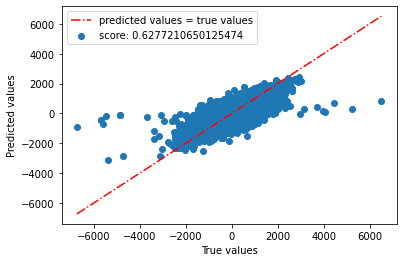

In [10]:
plotPred(scores, preds)

#### We test our model with some random positions.

5r2/1b1p3p/p3k3/1pR5/8/3P4/P1P4P/5K2 w - - 1 34
stockfish score: -540
pred score: -658


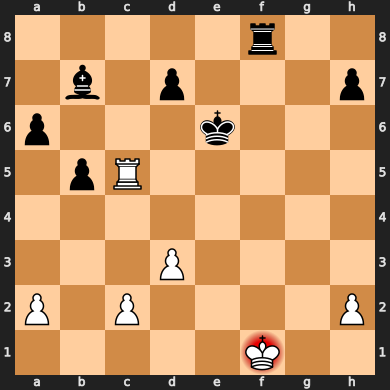

In [11]:
import sys
import chess
sys.path.insert(1, 'Classes/')
from dataset_utils import encodeBoard
from ScoreGetter import ScoreGetter

score_getter = ScoreGetter('/usr/local/bin/stockfish', 'eval', 'go depth 1')

df = pd.read_csv('Datasets/raw_dataset_13M.csv', nrows=1000)
fens = df['board'].values

fen = fens[np.random.randint(fens.shape[0])]
print(fen)
e = np.array(encodeBoard(fen)).reshape(1, -1)
print(f'stockfish score: {score_getter.getScore(fen)}')
print(f'pred score: {int(model.predict(e).flatten()[0])}')

chess.Board(fen)

In [12]:
model.save('../model', save_format='tf')

INFO:tensorflow:Assets written to: ../model/assets
